In [193]:
# Set of colours for the first data
color_SSN = 'royalblue'  # Colour for the data points
color_SSN_uncert = 'darkblue'  # Colour for the uncertainties

# Set of colours for the second data
color_WSO = 'darkorange'  # Colour for the data points
color_WSO_uncert = 'crimson'  # Colour for the uncertainties

### Indlæsning af data

Undersøger om der er forsinkelse på solpletcyklussen ift. magnetfeltscyklussen (hysterese).

Jeg har slettet rækker uden målinger og tilføjet en ny delimiter.

In [173]:
import re

# Åbn den oprindelige fil i læsetilstand og den nye fil i skrivetilstand
with open(r'C:\Users\marcu\OneDrive\Documents\GitHub\Solpletter_projekt\Magnus carlsen\data\WSO_polar2.csv', 'r') as original_file, open('WSO_polar2_fixed.csv', 'w') as new_file:
    # Læs hver linje fra den oprindelige fil
    for line in original_file:
        new_line = ''
        replace_next = False
        # Loop over tegnene i linjen
        for char in line:
            # Hvis tegnet er et mellemrum og replace_next er True, erstattes det med et komma
            if char == ' ' and replace_next:
                new_line += ','
                replace_next = False
            else:
                new_line += char
                # Hvis tegnet ikke er et mellemrum, sættes replace_next til True
                if char != ' ':
                    replace_next = True
        # Hvis "XXX" ikke er i den nye linje, skrives den til den nye fil (sørger for at fjerne rækker uden målinger)
        if "XXX" not in new_line:
            new_file.write(new_line)

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Indlæs data

loc1 = r"C:\Users\marcu\OneDrive\Documents\GitHub\Solpletter_projekt\Magnus carlsen\data\13-month smoothed monthly total sunspot number 1-1749 to now.csv"
loc2 = r"C:\Users\marcu\OneDrive\Documents\GitHub\Solpletter_projekt\Magnus carlsen\data\WSO_polar2_fixed.csv"

column_names = ['Year', 'Year_fraction', 'Monthly_smoothed_sunspot_number', 'U1', 'U2', 'U3']
sunspot_raw_data = pd.read_csv(loc1, names=column_names, delimiter=';')
sunspot_raw_data = sunspot_raw_data.iloc[6:-6]

column_names = ['Date', 'North', 'South', 'Average', 'val4', 'colon', 'val5', 'val6', 'val7']
wso_raw_data = pd.read_csv(loc2, names=column_names, delimiter=',')

# Sunspot data
sunspot_date_fraction_arr = sunspot_raw_data['Year_fraction'].values.astype(float)
sunspot_number_arr = sunspot_raw_data['Monthly_smoothed_sunspot_number'].values.astype(float)

# WSO data
wso_date_arr = wso_raw_data['Date'].values
wso_north_arr = wso_raw_data['North'].values.astype(float)
wso_south_arr = wso_raw_data['South'].values.astype(float)
wso_average_arr = wso_raw_data['Average'].values.astype(float)

# Konverter til absolutværdi af gennemsnit
wso_average_arr = np.abs(wso_average_arr)

# Konverter datoer til brøkdele af år
wso_date_fraction_arr = np.zeros(len(wso_date_arr))
for i in range(len(wso_date_arr)):
    date = wso_date_arr[i]
    year = int(date[:4])
    month = int(date[5:7])
    day = int(date[8:10])
    wso_date_fraction_arr[i] = year + (30.4375 * (month - 1) + day) / 365.25

print(wso_date_fraction_arr)



[1976.41820671 1976.44404517 1976.47142368 ... 2024.00154004 2024.02737851
 2024.05475702]


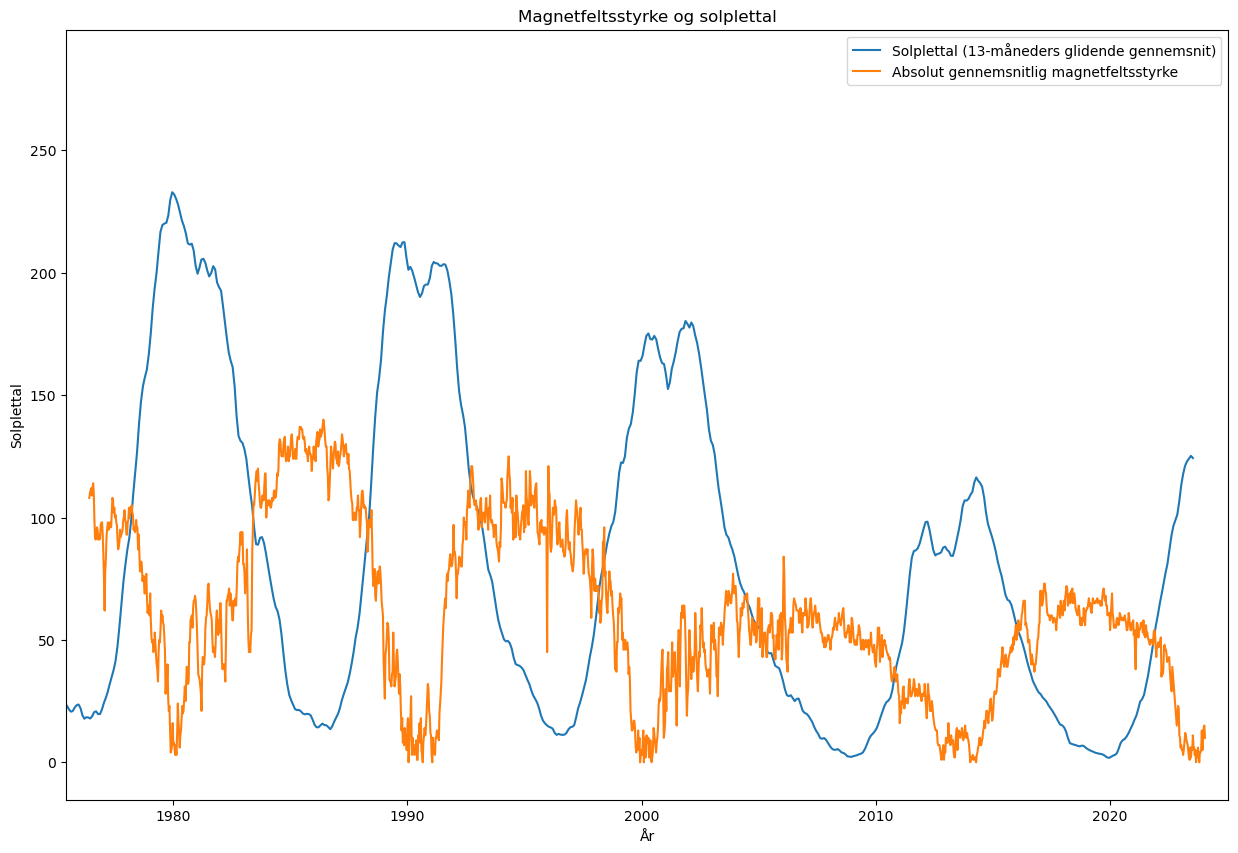

In [175]:
# Plot data
plt.figure(figsize=(15, 10))
plt.plot(sunspot_date_fraction_arr, sunspot_number_arr, label="Solplettal (13-måneders glidende gennemsnit)")
plt.plot(wso_date_fraction_arr, wso_average_arr, label="Absolut gennemsnitlig magnetfeltsstyrke")
plt.xlabel("År")
plt.ylabel("Solplettal")
plt.title("Magnetfeltsstyrke og solplettal")
plt.legend()

# Vis kun området med magnetfeltsdata
plt.xlim(np.min(wso_date_fraction_arr) - 1, np.max(wso_date_fraction_arr) + 1)

plt.show()

### Hysterese

Næste trin er at finde minima i magnetfeltsstyrken og maksima i antallet af solpletter for at tjekke hysterese. Ummidelbart ser der ud til at være en forsinkelse ift. magnetfeltsskiftet.

In [176]:
def rebin(arr, n):
    # Konverter det oprindelige array fra np.array til en liste (gør det nemmere at slette elementer)
    original_arr = list(arr)

    # De nye rebinnede arrays har længden N/n
    rebinned_arr = np.zeros(int(np.floor(len(arr) / n)))
    rebinned_arr_uncert = np.zeros(int(np.floor(len(arr) / n)))

    for i in range(len(rebinned_arr)):
        # Vælg de første n elementer i det oprindelige array
        elems = original_arr[:n]
        # Fjern elementerne fra det oprindelige array
        del original_arr[:n]

        # Beregn gennemsnit og tilføj til rebinned arr
        rebinned_arr[i] = np.mean(elems)

        # Beregn std og usikkerhed og tilføj til usikkerhed på rebinned arr
        std = np.std(elems)
        uncert = std / np.sqrt(n)
        
        rebinned_arr_uncert[i] = uncert
    
    # Returner arraysne
    return [rebinned_arr, rebinned_arr_uncert]

In [177]:
# Rebin magnetfeltsdata for at mindske støj
# Find tal der går op i antallet af datapunkter
num = len(wso_average_arr)
res = []
for i in range(1, int(num/2) + 1):
    if num % i == 0:
        res.append(i)

print(num)
print(res)

1732
[1, 2, 4, 433, 866]


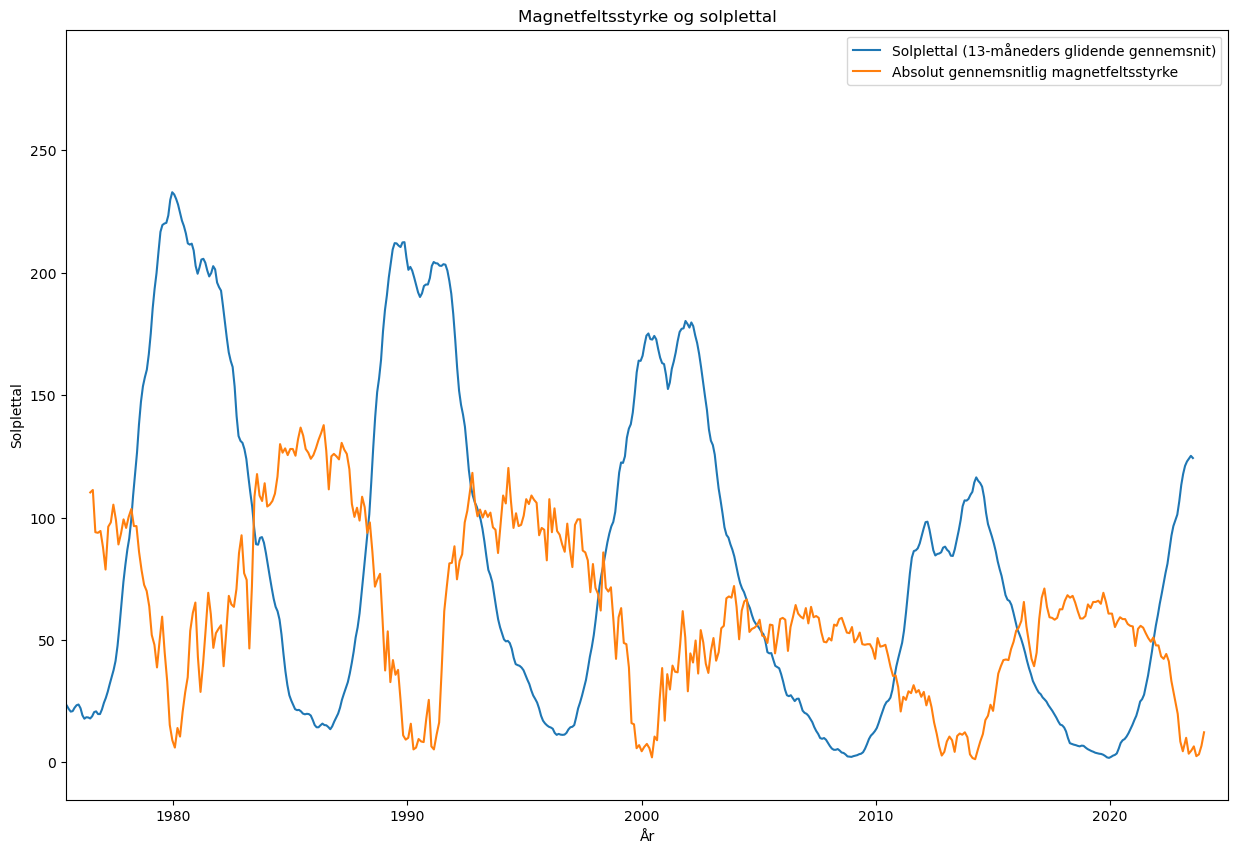

In [178]:
# Rebin med n = 4

rebinned_wso_average_arr, rebinned_wso_average_uncert = rebin(wso_average_arr, 4)
rebinned_wso_date_fraction_arr, rebinned_wso_date_fraction_uncert = rebin(wso_date_fraction_arr, 4)

# Plot rebinned data
plt.figure(figsize=(15, 10))
plt.plot(sunspot_date_fraction_arr, sunspot_number_arr, label="Solplettal (13-måneders glidende gennemsnit)")
plt.plot(rebinned_wso_date_fraction_arr, rebinned_wso_average_arr, label="Absolut gennemsnitlig magnetfeltsstyrke")
plt.xlabel("År")
plt.ylabel("Solplettal")
plt.title("Magnetfeltsstyrke og solplettal")
plt.legend()

# Vis kun området med magnetfeltsdata
plt.xlim(np.min(wso_date_fraction_arr) - 1, np.max(wso_date_fraction_arr) + 1)

plt.show()


### Find minima/maksima

Har ikke tid til peakfinding algoritmer så jeg leder bare i nogle intervaller omkring minima/maksima

In [179]:
# Minima

# Størrelse af intervallerne
h = 3

min_I_1 = [1980 - h, 1980 + h]
min_I_2 = [1990 - h, 1990 + h]
min_I_3 = [2000 - h, 2000 + h]
min_I_4 = [2015 - h, 2015 + h]
# Sidste interval går til datoen for de nyeste data
min_I_5 = [2020, max(wso_date_fraction_arr)]

# Find mindsteværdier i intervallerne
# I formatet [dato, værdi]
wso_minima = []

for interval in [min_I_1, min_I_2, min_I_3, min_I_4, min_I_5]:
    # Find index for mindste værdi i intervallet
    min_index = np.argmin(wso_average_arr[(wso_date_fraction_arr > interval[0]) & (wso_date_fraction_arr < interval[1])])
    # Find index for mindste værdi i det oprindelige array
    min_index = np.where(wso_date_fraction_arr == wso_date_fraction_arr[(wso_date_fraction_arr > interval[0]) & (wso_date_fraction_arr < interval[1])][min_index])
    # Tilføj mindste værdi til listen
    wso_minima.append([wso_date_fraction_arr[min_index][0], wso_average_arr[min_index][0]])


In [180]:
# Minima

# Størrelse af intervallerne
h = 3

min_I_1 = [1980 - h, 1980 + h]
min_I_2 = [1990 - h, 1990 + h]
min_I_3 = [2000 - h, 2000 + h]
min_I_4 = [2015 - h, 2015 + h]
# Sidste interval går til datoen for de nyeste data
min_I_5 = [2020, max(rebinned_wso_date_fraction_arr)]

# Find mindsteværdier i intervallerne
# I formatet [dato, værdi]
rebinned_wso_minima = []

for interval in [min_I_1, min_I_2, min_I_3, min_I_4, min_I_5]:
    # Find index for mindste værdi i intervallet
    min_index = np.argmin(rebinned_wso_average_arr[(rebinned_wso_date_fraction_arr > interval[0]) & (rebinned_wso_date_fraction_arr < interval[1])])
    # Find index for mindste værdi i det oprindelige array
    min_index = np.where(rebinned_wso_date_fraction_arr == rebinned_wso_date_fraction_arr[(rebinned_wso_date_fraction_arr > interval[0]) & (rebinned_wso_date_fraction_arr < interval[1])][min_index])
    # Tilføj mindste værdi til listen
    rebinned_wso_minima.append([rebinned_wso_date_fraction_arr[min_index][0], rebinned_wso_average_arr[min_index][0]])


In [181]:
# Maksima

# Størrelse af intervallerne
h = 3

max_I_1 = [1980 - h, 1980 + h]
max_I_2 = [1990 - h, 1990 + h]
max_I_3 = [2001 - h, 2001 + h]
max_I_4 = [2015 - h, 2015 + h]
# Sidste interval går til datoen for de nyeste data
max_I_5 = [2020, max(wso_date_fraction_arr)]

# Find størsteværdier i intervallerne
# I formatet [dato, værdi]
sunspot_number_maxima = []

for interval in [max_I_1, max_I_2, max_I_3, max_I_4, max_I_5]:
    # Find index for største værdi i intervallet
    max_index = np.argmax(sunspot_number_arr[(sunspot_date_fraction_arr > interval[0]) & (sunspot_date_fraction_arr < interval[1])])
    # Find index for største værdi i det oprindelige array
    max_index = np.where(sunspot_date_fraction_arr == sunspot_date_fraction_arr[(sunspot_date_fraction_arr > interval[0]) & (sunspot_date_fraction_arr < interval[1])][max_index])
    # Tilføj største værdi til listen
    sunspot_number_maxima.append([sunspot_date_fraction_arr[max_index][0], sunspot_number_arr[max_index][0]])




Tid til at plotte.

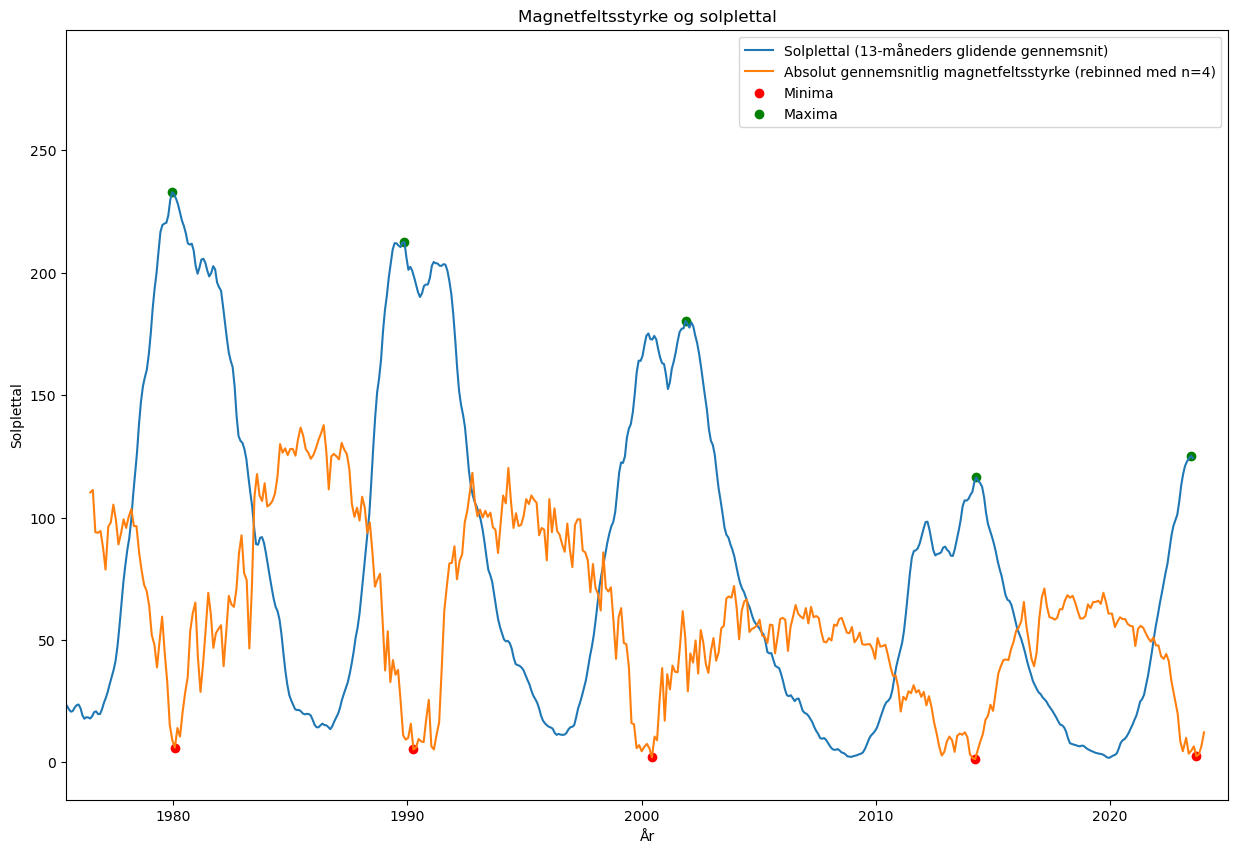

In [182]:
# Plot minima og maxima
plt.figure(figsize=(15, 10))
plt.plot(sunspot_date_fraction_arr, sunspot_number_arr, label="Solplettal (13-måneders glidende gennemsnit)")
plt.plot(rebinned_wso_date_fraction_arr, rebinned_wso_average_arr, label="Absolut gennemsnitlig magnetfeltsstyrke (rebinned med n=4)")
plt.scatter([elem[0] for elem in rebinned_wso_minima], [elem[1] for elem in rebinned_wso_minima], color='red', label="Minima")
plt.scatter([elem[0] for elem in sunspot_number_maxima], [elem[1] for elem in sunspot_number_maxima], color='green', label="Maxima")
plt.xlabel("År")
plt.ylabel("Solplettal")
plt.title("Magnetfeltsstyrke og solplettal")
plt.legend()

# Vis kun området med magnetfeltsdata
plt.xlim(np.min(wso_date_fraction_arr) - 1, np.max(wso_date_fraction_arr) + 1)

plt.show()


Udregn tiden mellem minima og maksima

In [183]:
timediffs = []

for i in range(len(wso_minima)):
    timediffs.append(sunspot_number_maxima[i][0] - wso_minima[i][0])

print(timediffs)

[-0.1268733744009296, -0.17528131416838733, 1.938168377823331, 0.2551457905544794, -0.2191423682409095]


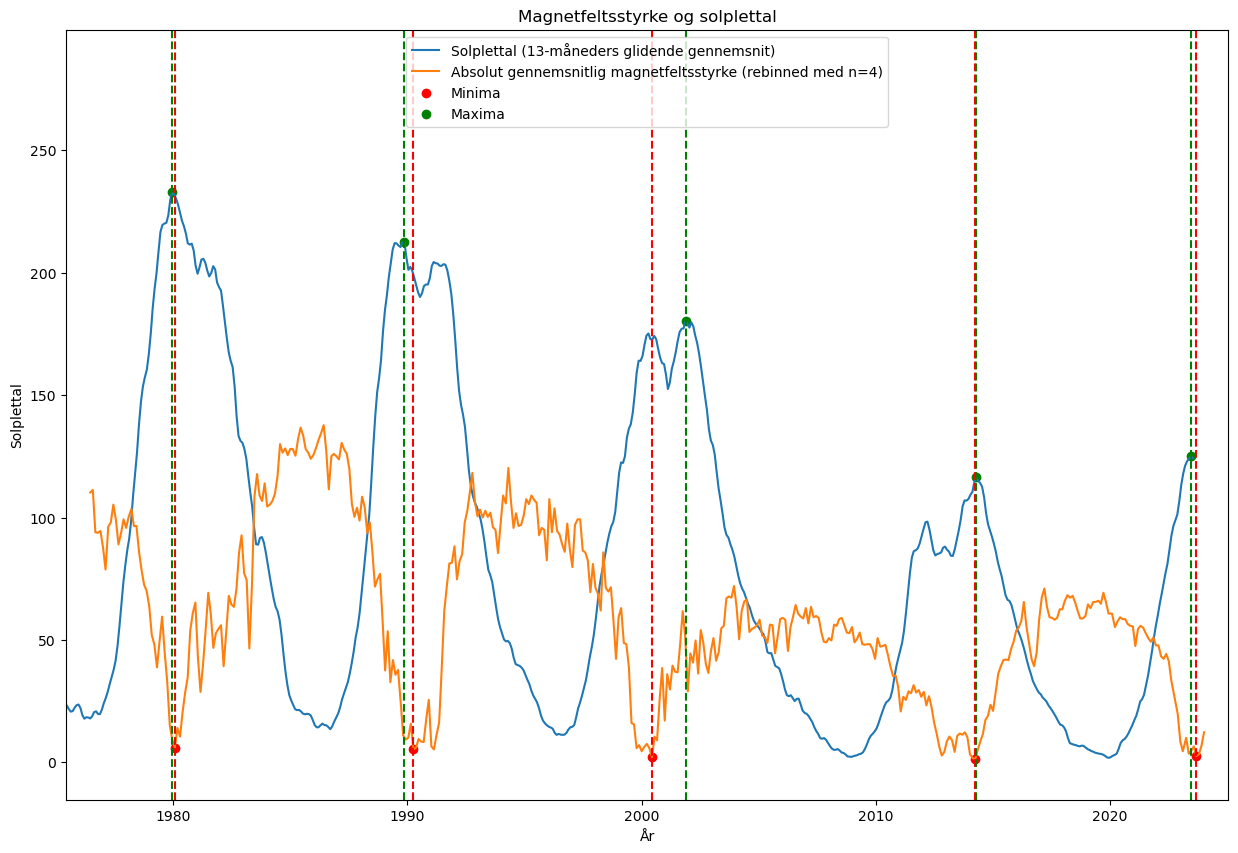

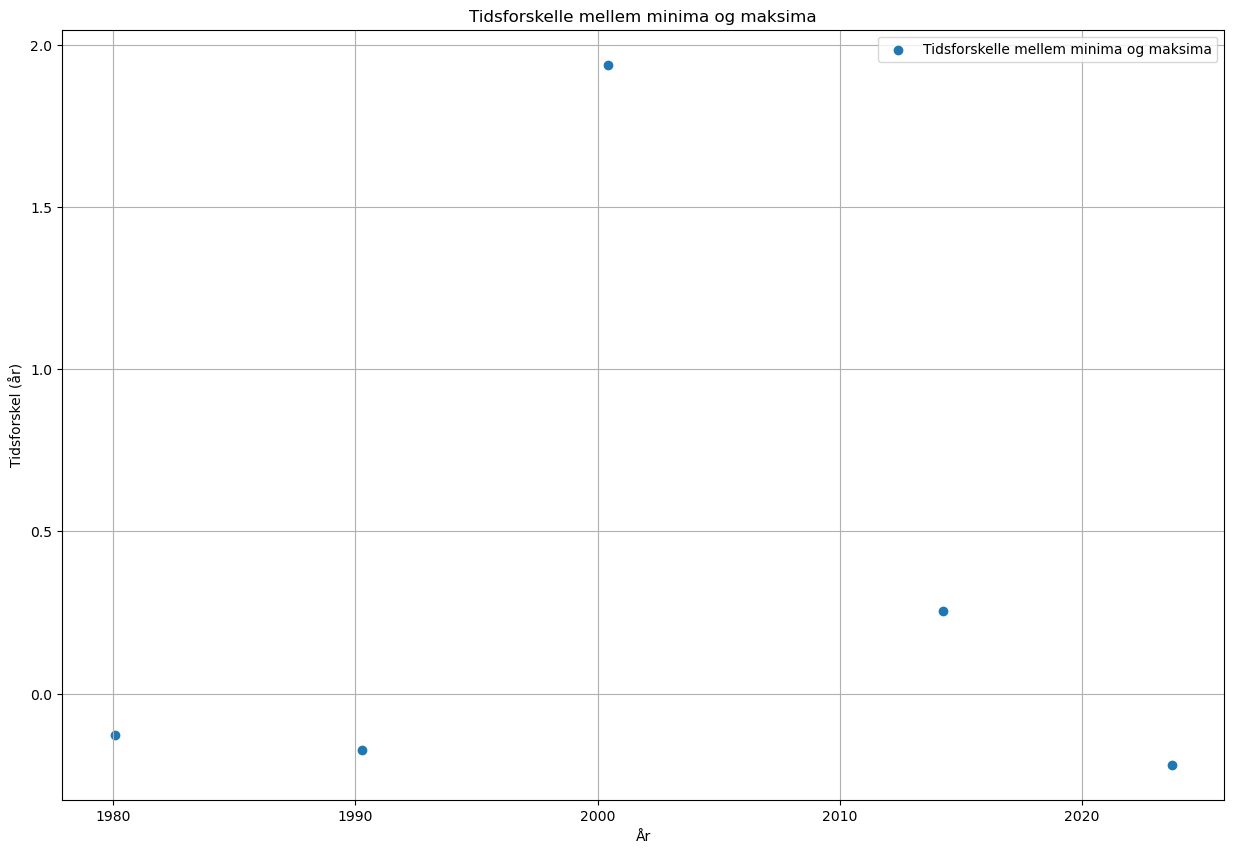

-0.1268733744009296
-0.17528131416838733
1.938168377823331
0.2551457905544794
-0.2191423682409095
Den gennemsnitlige tidsforskel er 0.33 år


In [184]:
# Plot data
plt.figure(figsize=(15, 10))
plt.plot(sunspot_date_fraction_arr, sunspot_number_arr, label="Solplettal (13-måneders glidende gennemsnit)")
plt.plot(rebinned_wso_date_fraction_arr, rebinned_wso_average_arr, label="Absolut gennemsnitlig magnetfeltsstyrke (rebinned med n=4)")
plt.scatter([elem[0] for elem in rebinned_wso_minima], [elem[1] for elem in rebinned_wso_minima], color='red', label="Minima")
plt.scatter([elem[0] for elem in sunspot_number_maxima], [elem[1] for elem in sunspot_number_maxima], color='green', label="Maxima")

# Plot lodrette linjer for minima og maksima
for elem in rebinned_wso_minima:
    plt.axvline(x=elem[0], color='red', linestyle='--')
for elem in sunspot_number_maxima:
    plt.axvline(x=elem[0], color='green', linestyle='--')


plt.xlabel("År")
plt.ylabel("Solplettal")
plt.title("Magnetfeltsstyrke og solplettal")
plt.legend()

# Vis kun området med magnetfeltsdata
plt.xlim(np.min(wso_date_fraction_arr) - 1, np.max(wso_date_fraction_arr) + 1)

plt.show()



# Plot tidsforskelle
plt.figure(figsize=(15, 10))
plt.grid()
plt.scatter([elem[0] for elem in rebinned_wso_minima], timediffs, label="Tidsforskelle mellem minima og maksima")
plt.xlabel("År")
plt.ylabel("Tidsforskel (år)")
plt.title("Tidsforskelle mellem minima og maksima")
plt.legend()

plt.show()

for timediff in timediffs:
    print(timediff)

print("Den gennemsnitlige tidsforskel er{: .2f} år".format(np.mean(timediffs)))



# Med smoothed magnetfeltsdata

In [185]:
# Smukke farver trololulu
color_SSN = "crimson"
color_SSN_uncert = "black"
color_WSO = "teal"
color_WSO_uncert = "purple"

# Set of colours for the first data
color_SSN = 'royalblue'  # Colour for the data points
color_SSN_uncert = 'darkblue'  # Colour for the uncertainties

# Set of colours for the second data
color_WSO_uncert = 'peachpuff'  # Colour for the data points
color_WSO_uncert = 'darkorange'  # Colour for the uncertainties




C:\Users\marcu\AppData\Local\Temp\ipykernel_3476\3959441226.py:24: RuntimeWarning: invalid value encountered in sqrt
  SSN_uncert_arr.append(SSN_std_arr[i]/np.sqrt(N_obs_arr[i]))
C:\Users\marcu\AppData\Local\Temp\ipykernel_3476\3959441226.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  SSN_uncert_arr.append(SSN_std_arr[i]/np.sqrt(N_obs_arr[i]))


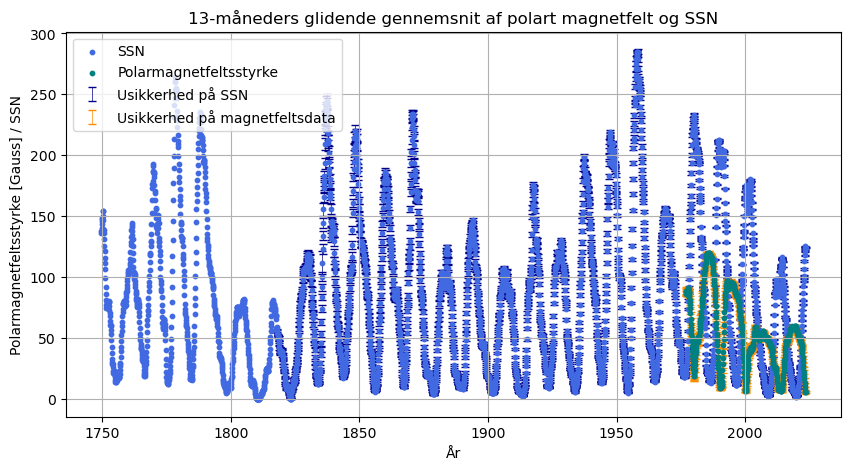

In [186]:
loc1 = r"C:\Users\marcu\OneDrive\Documents\GitHub\Solpletter_projekt\Magnus carlsen\data\WSO_smoothed.csv"

column_names = ['Date', 'Magnetic_field', 'Uncertainty']
wso_smoothed_data = pd.read_csv(loc1, names=column_names, delimiter=',', skiprows=1)
wso_smoothed_date_arr = wso_smoothed_data['Date'].values.astype(float)
wso_smoothed_magnetic_field_arr = wso_smoothed_data['Magnetic_field'].values.astype(float)
wso_smoothed_uncert_arr = wso_smoothed_data['Uncertainty'].values.astype(float)

loc2 = r"C:\Users\marcu\OneDrive\Documents\GitHub\Solpletter_projekt\Magnus carlsen\data\13-month smoothed monthly total sunspot number 1-1749 to now.csv"

column_names = ['Year', 'Year_fraction', 'Monthly_smoothed_sunspot_number', 'SSN_STD', 'N_obs', 'DefProvMarker']
sunspot_raw_data = pd.read_csv(loc2, names=column_names, delimiter=';', skiprows=1)
sunspot_raw_data = sunspot_raw_data.iloc[6:-6]

# Sunspot data
SSN_date_fraction_arr = sunspot_raw_data['Year_fraction'].values.astype(float)
SSN_arr = sunspot_raw_data['Monthly_smoothed_sunspot_number'].values.astype(float)
SSN_std_arr = abs(sunspot_raw_data['SSN_STD'].values.astype(float))
N_obs_arr = sunspot_raw_data['N_obs'].values.astype(float)

# Usikkerhed beregnes med "usikkerheden på middelværdien"
SSN_uncert_arr = []
for i in range(len(SSN_arr)):
    SSN_uncert_arr.append(SSN_std_arr[i]/np.sqrt(N_obs_arr[i]))

# Plot
ScatterSize = 10
plt.figure(figsize=(10, 5))

plt.grid(True)
plt.scatter(SSN_date_fraction_arr, SSN_arr, label='SSN', s=ScatterSize, c=color_SSN)
plt.errorbar(SSN_date_fraction_arr, SSN_arr, label="Usikkerhed på SSN", yerr=SSN_uncert_arr, fmt='none', color=color_SSN_uncert, elinewidth=0.5, capsize=3,  zorder=0)
plt.scatter(wso_smoothed_date_arr, wso_smoothed_magnetic_field_arr, label='Polarmagnetfeltsstyrke', s=ScatterSize, c=color_WSO)
plt.errorbar(wso_smoothed_date_arr, wso_smoothed_magnetic_field_arr, label="Usikkerhed på magnetfeltsdata", yerr=wso_smoothed_uncert_arr, fmt='none', color=color_WSO_uncert, elinewidth=0.5, capsize=3,  zorder=0)
plt.xlabel('År')
plt.ylabel('Polarmagnetfeltsstyrke [Gauss] / SSN')
plt.title('13-måneders glidende gennemsnit af polart magnetfelt og SSN')
plt.legend()
plt.show()


In [187]:
# Maksima

# Størrelse af intervallerne
h = 5

max_I_1 = [1980 - h, 1980 + h]
max_I_2 = [1990 - h, 1990 + h]
max_I_3 = [2001 - h, 2001 + h]
max_I_4 = [2015 - h, 2015 + h]
# Sidste interval går til datoen for de nyeste data
max_I_5 = [2020, max(SSN_date_fraction_arr)]

# Find størsteværdier i intervallerne
# I formatet [dato, værdi]
sunspot_number_maxima = []

for interval in [max_I_1, max_I_2, max_I_3, max_I_4, max_I_5]:
    # Find index for største værdi i intervallet
    max_index = np.argmax(SSN_arr[(SSN_date_fraction_arr > interval[0]) & (SSN_date_fraction_arr < interval[1])])
    # Find index for største værdi i det oprindelige array
    max_index = np.where(SSN_date_fraction_arr == SSN_date_fraction_arr[(SSN_date_fraction_arr > interval[0]) & (SSN_date_fraction_arr < interval[1])][max_index])
    # Tilføj største værdi til listen
    sunspot_number_maxima.append([SSN_date_fraction_arr[max_index][0], SSN_arr[max_index][0]])

# Minima

# Størrelse af intervallerne

min_I_1 = [1980 - h, 1980 + h]
min_I_2 = [1990 - h, 1990 + h]
min_I_3 = [1999, 2002]
min_I_4 = [2010, 2015]
# Sidste interval går til datoen for de nyeste data
min_I_5 = [2023, max(wso_smoothed_date_arr)]

# Find mindsteværdier i intervallerne
# I formatet [dato, værdi]
wso_minima = []

for interval in [min_I_1, min_I_2, min_I_3, min_I_4, min_I_5]:
    # Find index for mindste værdi i intervallet
    min_index = np.argmin(wso_smoothed_magnetic_field_arr[(wso_smoothed_date_arr > interval[0]) & (wso_smoothed_date_arr < interval[1])])
    # Find index for mindste værdi i det oprindelige array
    min_index = np.where(wso_smoothed_date_arr == wso_smoothed_date_arr[(wso_smoothed_date_arr > interval[0]) & (wso_smoothed_date_arr < interval[1])][min_index])
    # Tilføj mindste værdi til listen
    wso_minima.append([wso_smoothed_date_arr[min_index][0], wso_smoothed_magnetic_field_arr[min_index][0]])



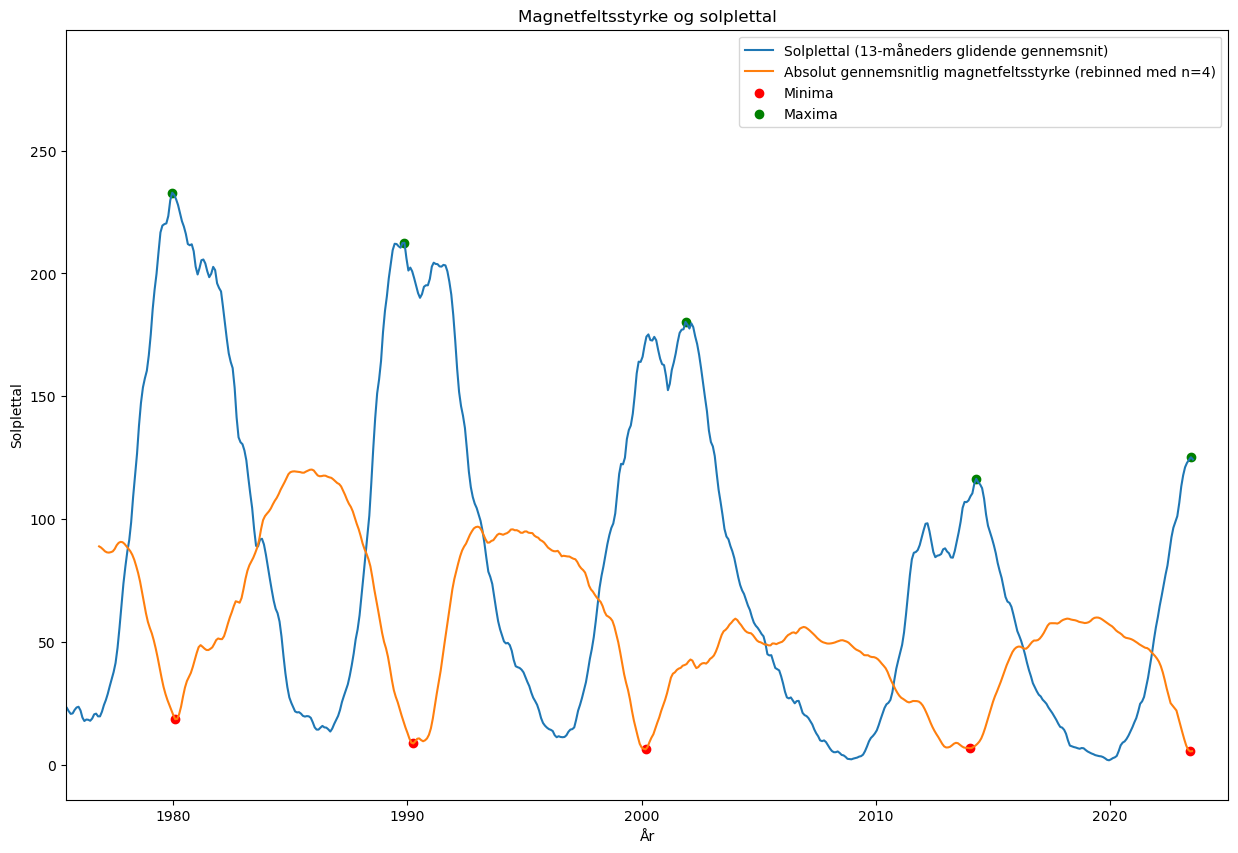

In [188]:
# Plot minima og maxima
plt.figure(figsize=(15, 10))
plt.plot(SSN_date_fraction_arr, SSN_arr, label="Solplettal (13-måneders glidende gennemsnit)")
plt.plot(wso_smoothed_date_arr, wso_smoothed_magnetic_field_arr, label="Absolut gennemsnitlig magnetfeltsstyrke (rebinned med n=4)")
plt.scatter([elem[0] for elem in wso_minima], [elem[1] for elem in wso_minima], color='red', label="Minima")
plt.scatter([elem[0] for elem in sunspot_number_maxima], [elem[1] for elem in sunspot_number_maxima], color='green', label="Maxima")
plt.xlabel("År")
plt.ylabel("Solplettal")
plt.title("Magnetfeltsstyrke og solplettal")
plt.legend()

# Vis kun området med magnetfeltsdata
plt.xlim(np.min(wso_date_fraction_arr) - 1, np.max(wso_date_fraction_arr) + 1)

plt.show()


In [189]:
# Fjern cyklus 25
wso_minima.pop(-1)
sunspot_number_maxima.pop(-1)

[2023.453, 125.2]

In [190]:
timediffs = []

for i in range(len(wso_minima)):
    timediffs.append(sunspot_number_maxima[i][0] - wso_minima[i][0])

print(timediffs)

[-0.1280711841206994, -0.37873785078704714, 1.7045954825464378, 0.28526214921294013]


## 13mGG wso-data

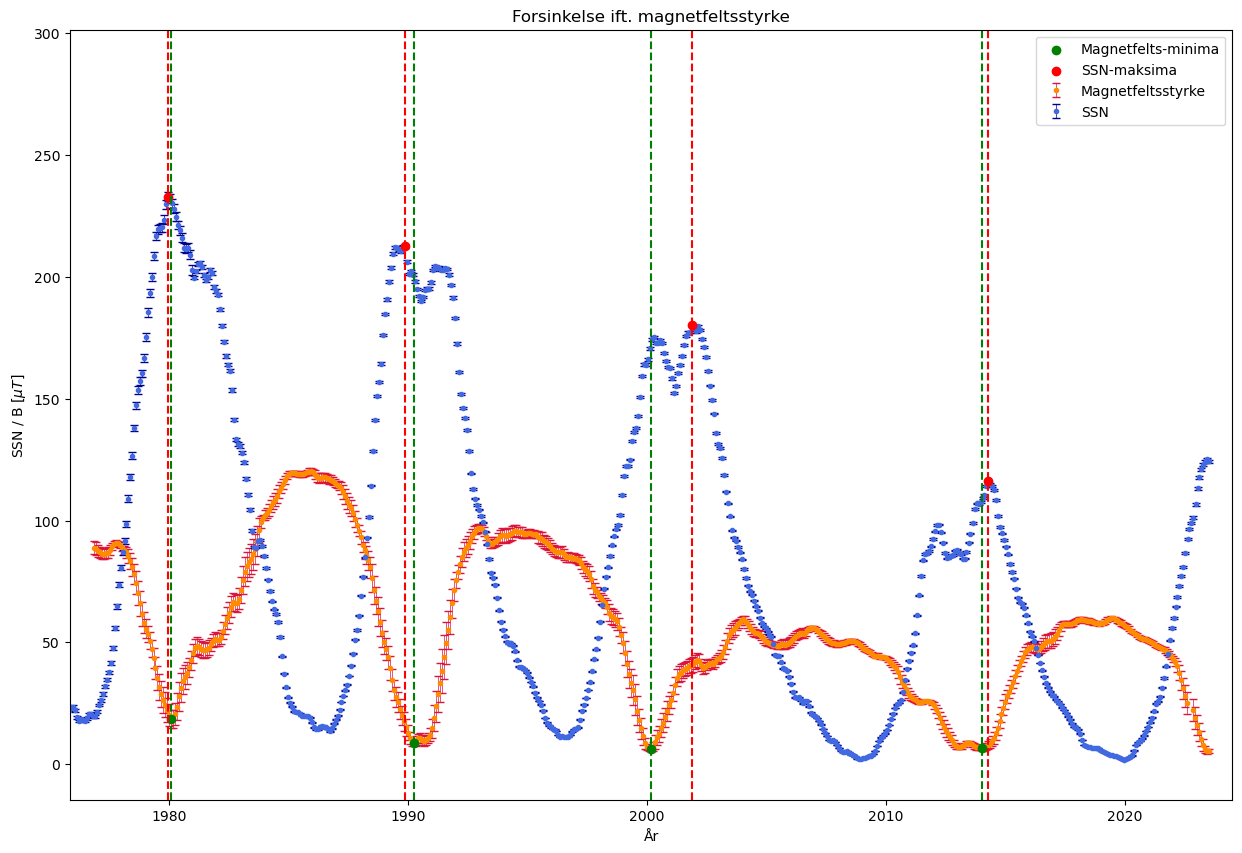

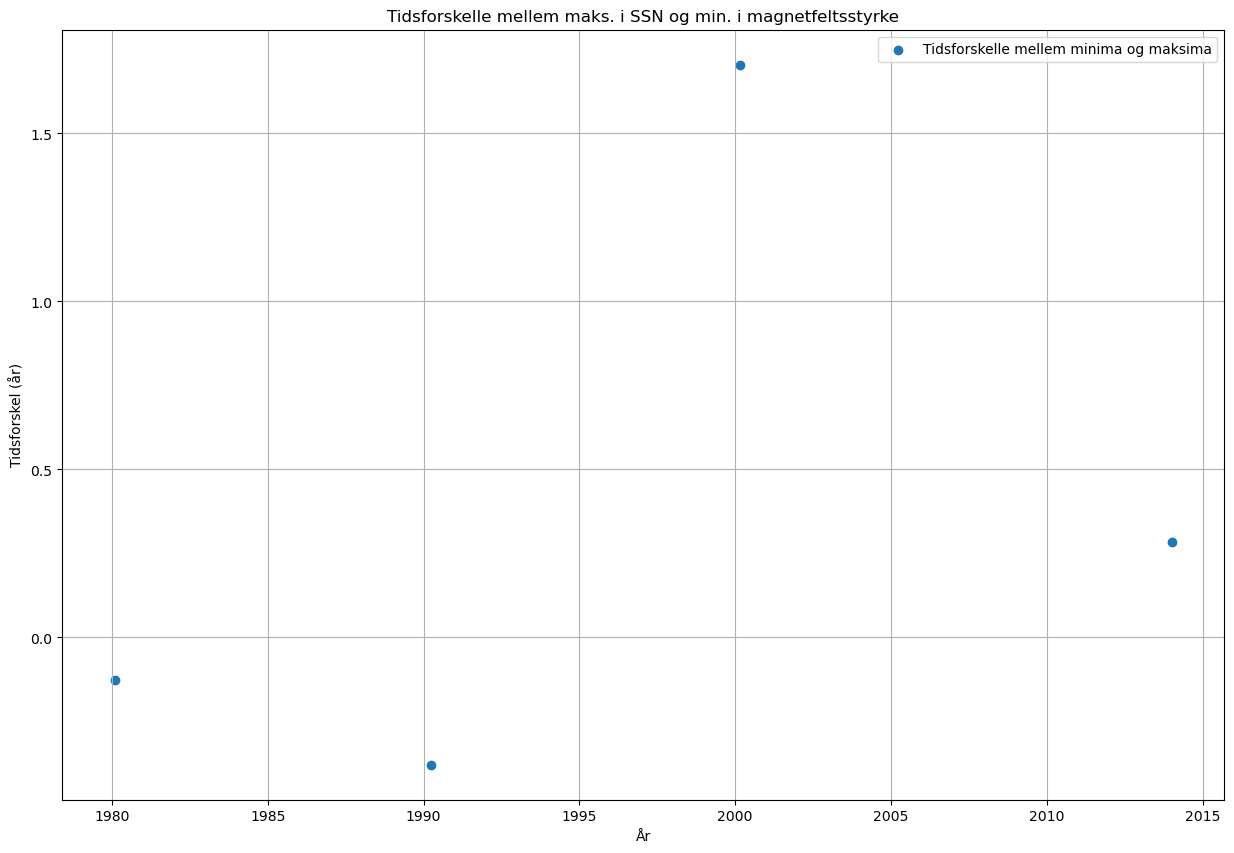

-0.1280711841206994
-0.37873785078704714
1.7045954825464378
0.28526214921294013
Den gennemsnitlige tidsforskel er 0.37 år


In [195]:
# Plot data
plt.figure(figsize=(15, 10))
# plt.scatter(SSN_date_fraction_arr, SSN_arr, label="Solplettal (13-måneders glidende gennemsnit)")
# plt.scatter(wso_smoothed_date_arr, wso_smoothed_magnetic_field_arr, label="Absolut gennemsnitlig magnetfeltsstyrke (rebinned med n=4)")

plt.errorbar(wso_smoothed_date_arr, wso_smoothed_magnetic_field_arr, label="Magnetfeltsstyrke", fmt='.', yerr=wso_smoothed_uncert_arr, ecolor=color_WSO_uncert, c=color_WSO, elinewidth=0.5, capsize=3,  zorder=0)
plt.errorbar(SSN_date_fraction_arr, SSN_arr, label="SSN", yerr=SSN_uncert_arr, fmt='.', ecolor=color_SSN_uncert, c=color_SSN, elinewidth=0.5, capsize=3,  zorder=0)


plt.scatter([elem[0] for elem in wso_minima], [elem[1] for elem in wso_minima], color='green', label="Magnetfelts-minima")
plt.scatter([elem[0] for elem in sunspot_number_maxima], [elem[1] for elem in sunspot_number_maxima], color='red', label="SSN-maksima")

# Plot lodrette linjer for minima og maksima
for elem in wso_minima:
    plt.axvline(x=elem[0], color='green', linestyle='--')
for elem in sunspot_number_maxima:
    plt.axvline(x=elem[0], color='red', linestyle='--')


plt.xlabel("År")
plt.ylabel(r"SSN / B [$\mu T$]")
plt.title("Forsinkelse ift. magnetfeltsstyrke")
plt.legend()

# Vis kun området med magnetfeltsdata
plt.xlim(np.min(wso_smoothed_date_arr) - 1, np.max(wso_smoothed_date_arr) + 1)

plt.show()



# Plot tidsforskelle
plt.figure(figsize=(15, 10))
plt.grid()
plt.scatter([elem[0] for elem in wso_minima], timediffs, label="Tidsforskelle mellem minima og maksima")
plt.xlabel("År")
plt.ylabel("Tidsforskel (år)")
plt.title("Tidsforskelle mellem maks. i SSN og min. i magnetfeltsstyrke")
plt.legend()

plt.show()

for timediff in timediffs:
    print(timediff)

print("Den gennemsnitlige tidsforskel er{: .2f} år".format(np.mean(timediffs)))



## Subplots med forsinkelseslinjer


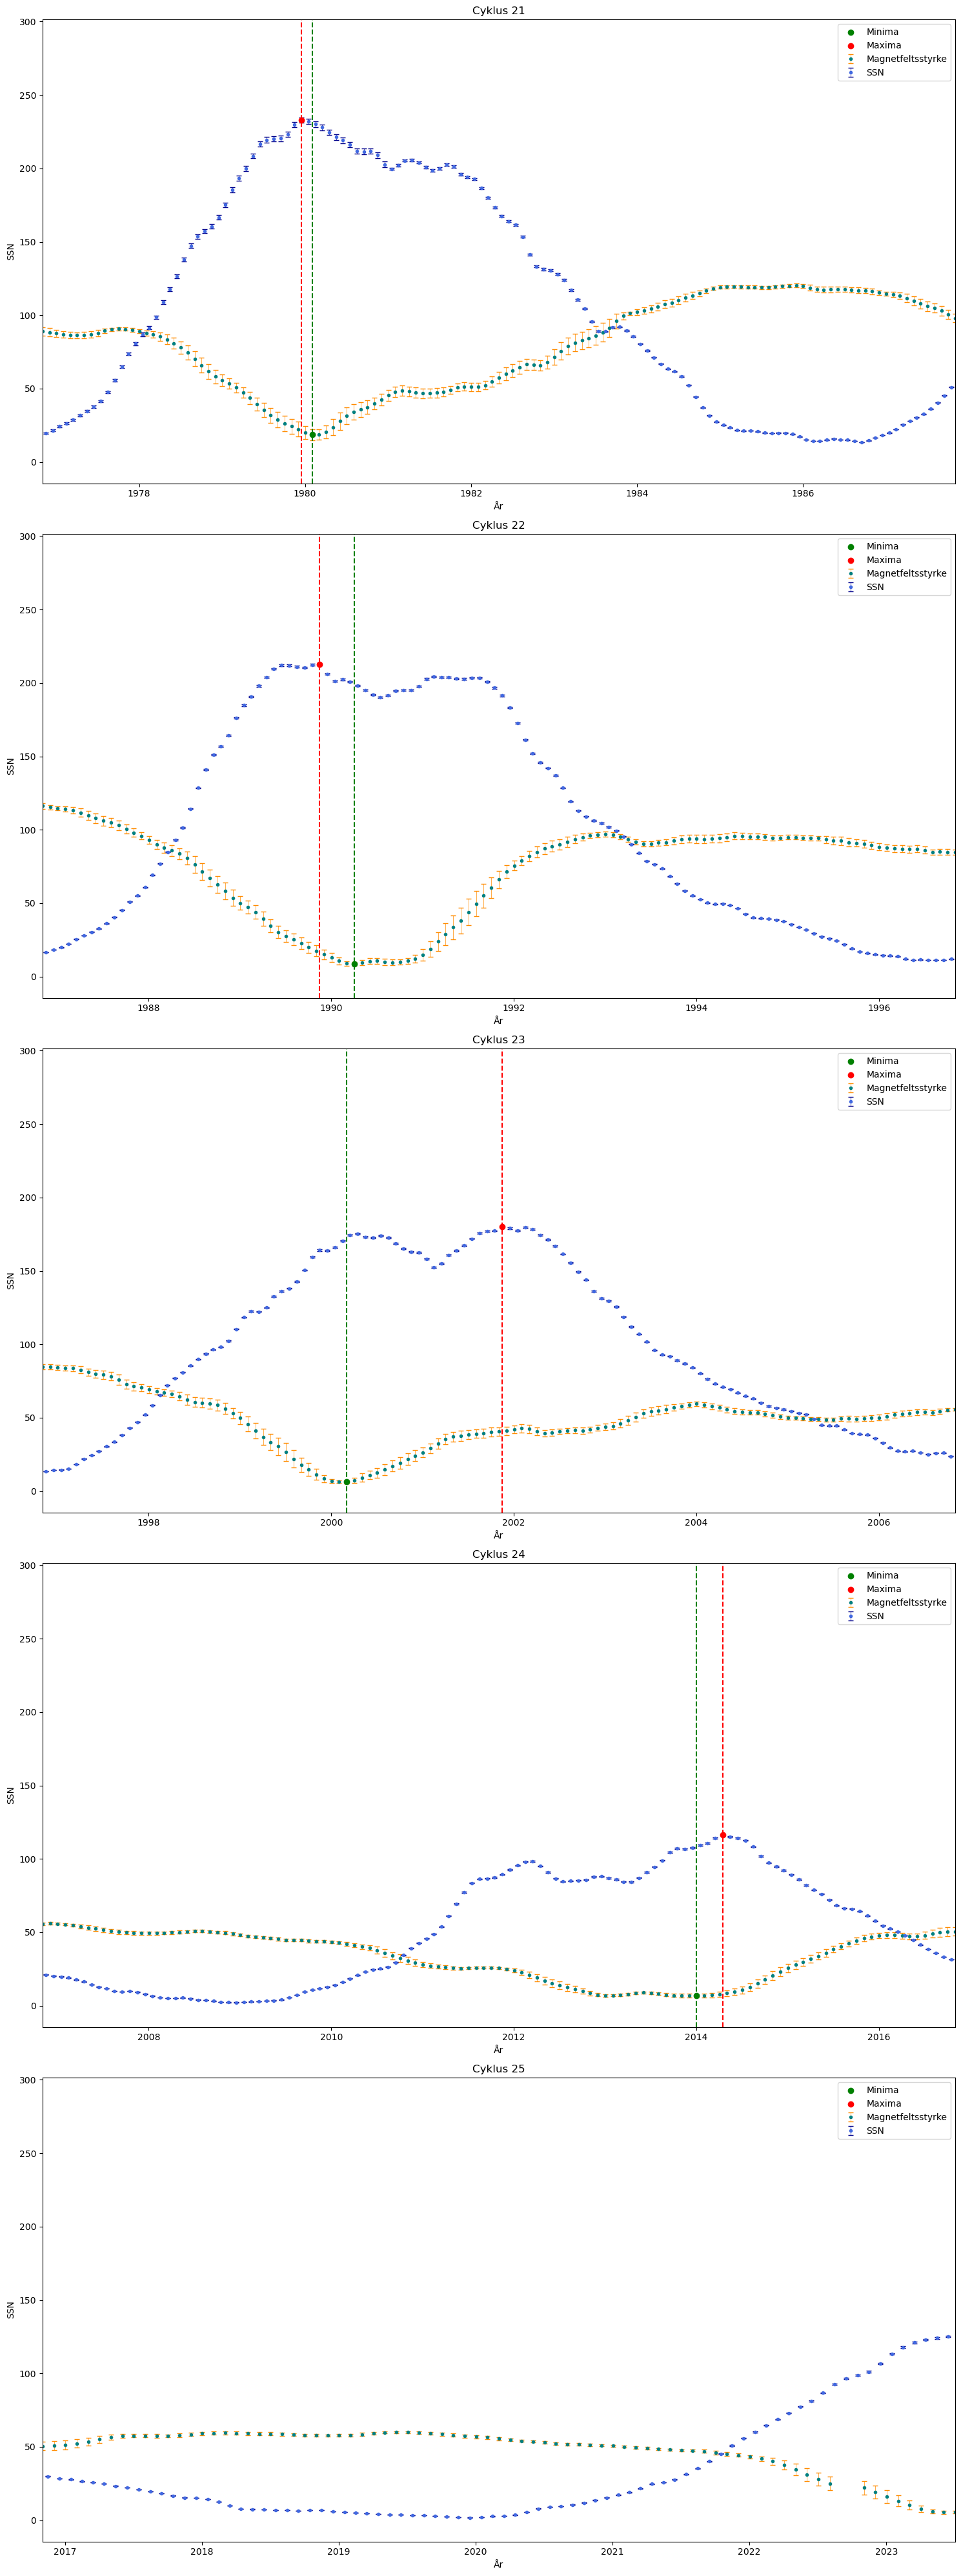

In [192]:
# Define intervals
interval1 = (np.min(wso_smoothed_date_arr), np.min(wso_smoothed_date_arr) + 11)
interval2 = (np.min(wso_smoothed_date_arr) + 10, np.min(wso_smoothed_date_arr) + 20)
interval3 = (np.min(wso_smoothed_date_arr) + 20, np.min(wso_smoothed_date_arr) + 30)
interval4 = (np.min(wso_smoothed_date_arr) + 30, np.min(wso_smoothed_date_arr) + 40)
interval5 = (np.min(wso_smoothed_date_arr) + 40, np.max(wso_smoothed_date_arr))

# Create figure with four subplots
fig, axs = plt.subplots(5, 1, figsize=(15, 40))

# List of intervals and axes for easy iteration
intervals = [interval1, interval2, interval3, interval4, interval5]
i = 21
for ax, interval in zip(axs, intervals):
    # Plot data
    ax.errorbar(wso_smoothed_date_arr, wso_smoothed_magnetic_field_arr, label="Magnetfeltsstyrke", fmt='.', yerr=wso_smoothed_uncert_arr, ecolor=color_WSO_uncert, c=color_WSO, elinewidth=0.5, capsize=3,  zorder=0)
    ax.errorbar(SSN_date_fraction_arr, SSN_arr, label="SSN", yerr=SSN_uncert_arr, fmt='.', ecolor=color_SSN_uncert, c=color_SSN, elinewidth=0.5, capsize=3,  zorder=0)

    ax.scatter([elem[0] for elem in wso_minima], [elem[1] for elem in wso_minima], color='green', label="Minima")
    ax.scatter([elem[0] for elem in sunspot_number_maxima], [elem[1] for elem in sunspot_number_maxima], color='red', label="Maxima")

    # Plot vertical lines for minima and maxima
    for elem in wso_minima:
        ax.axvline(x=elem[0], color='green', linestyle='--')
    for elem in sunspot_number_maxima:
        ax.axvline(x=elem[0], color='red', linestyle='--')

    ax.set_xlabel("År")
    ax.set_ylabel("SSN")
    ax.set_title(f"Cyklus {i}")
    ax.legend()

    # Only show the area with magnetic field data
    ax.set_xlim(interval)
    
    i += 1

plt.tight_layout()
plt.show()